# Edge of Stability with Associative Memory model

The goal of this notebook is to show edge of stability arising in the associative memory model considered in the paper ``Scaling laws for associative memories''.

In [1]:
import subprocess
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F

# be mindful of pseudo-random number generator
th.manual_seed(0)

## Model
We define the model.
We take random embeddings of both integer inputs $x$ and integer outputs $y$ as random vectors of the sphere in $\R^d$, respectively $e_x$ and $u_y$.
Then we map $x$ to $y$ through the model $y = f_W(x)$, where $W$ is a matrix of size $d \times d$ to be learned and that parameterizes
$$
    f_W(x) = \argmax_{y} \langle u_y, W e_x \rangle.
$$

In [2]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        d = E.shape[1]
        self.W = nn.Parameter(th.zeros(d, d))
        # self.W = nn.Parameter(th.randn(d, d) / sqrt(d))
        self.E = E
        self.U = U

    def forward(self, x):
        """
        Compute the score :math:`g(x, y) = u_y^\top W e_x`.
        """
        out = self.E[x] @ self.W
        out = out @ self.U
        return out

    def fit(self, x):
        """
        Compute the prediction :math:`f(x) = \operatorname{argmax}_y u_y^\top W e_x`.
        """
        score = self.forward(x)
        return score.argmax(dim=1)


## Data
Let's start with a small specification of the model.
Assume that the $y = x$ and the $x$ is taken uniformly at random over $n$ integers.
Later we could consider more complex model such as $y = f(x, \epsilon)$ where $\epsilon$ is a noise term, and $x$ to be non-uniform (which would reduce the "effective dimension").

In [3]:
# number of input tokens
n = 30

# probability of the inputs, a Zipf law of parameter alpha
alpha = 0                 # alpha = 0 means uniform distribution
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()

In [4]:
# association model
def f(x, epsilon=None):
    """
    Model of association between `x` and `y`.
    """
    return x

# noise level
epsilon = 0

# target associations
all_y = f(all_x, 0)

In [5]:
# memory dimension
d = 10

# random embeddings
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True).T 

# model
model = AssMem(E, U)

## Optimization procedure
We will learn the matrix $W$ by gradient descent on a surrogate loss function.
We use the softmax loss (which is convex in $W$)
$$
    \ell(W; x, y) = \log \left( \sum_{z} \exp \langle u_{z}, W e_x \rangle \right) - \langle u_y, W e_x \rangle.
$$
We begin with a constant step size $\eta$, and batch size equals one.
We begin with a constant step size $\eta$, and batch size equals one.
We could easily change the code to try out other optimization procedures.

In [6]:
# optimization parameter 
batch_size = 1
nb_epoch = 10000
T = nb_epoch * batch_size
lr = 1e-3

optimizer = th.optim.SGD(model.parameters(), lr=lr, momentum=0)
# scheduler = th.optim.lr_scheduler.StepLR(optimizer, nb_epoch // 10, gamma=0.1)

In [7]:
# training loop 

train_loss = th.zeros(nb_epoch)
test_loss = th.zeros(nb_epoch)

for i in range(nb_epoch):
    # get batch of data
    x = th.multinomial(proba, batch_size, replacement=True)
    y = f(x, epsilon)

    # compute loss
    score = model(x)
    loss = F.cross_entropy(score, y)
    
    # record statistics
    train_loss[i] = loss.item()
    with th.no_grad():
        pred = model.fit(all_x)
        test_loss[i] = proba[pred != all_y].sum().item()

    # update parameters with gradient descent
    loss.backward()
    optimizer.step()
    # scheduler.step()


## Visualization

We configure matplotlib to render nicely in a TeX file by notably compute the width of figures exactly (rather than resizing it in TeX).
You can find width of a LaTeX documents with \the\textwidth, and the font size with \expandafter\string\the\font
Here I assume that we use the `times` font with a size of 12pt, and a document of width 6.5in (or 472 pt).

In [8]:
width = 472 / 72

plt.rc('font', family='serif', size=12)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
plt.rc('text', usetex=usetex)
if usetex:
    plt.rc('text.latex', preamble=r'\usepackage{times}')

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


To average out the noise in the training procedure, we can use an exponential moving average

In [9]:
@th.jit.script
def ewma(x: th.Tensor, theta: float):
    r = th.zeros_like(x)
    r[0] = x[0]
    for i in range(1, x.shape[0]):
        r[i] = theta * r[i - 1] + (1 - theta) * x[i]
    return r

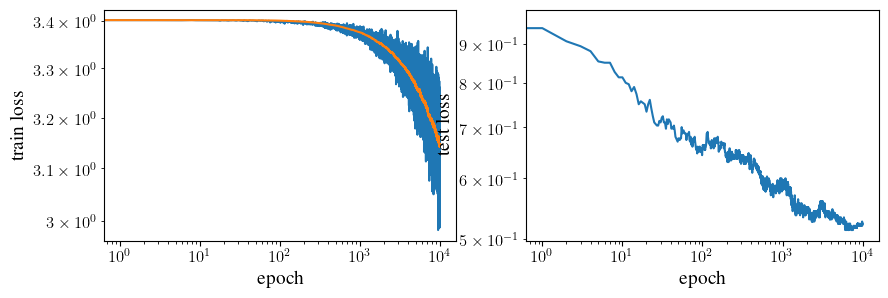

In [54]:
# # for TeX documents
# fig, ax = plt.subplots(1, 1, figsize=(.48 * width, .48 * width / 1.618))
# for visualization ease in this notebook
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(th.arange(nb_epoch), train_loss, label='train')
smooth_train_loss = ewma(train_loss, .99)
axes[0].plot(th.arange(nb_epoch), smooth_train_loss, label='train')
axes[1].plot(th.arange(nb_epoch), test_loss, label='test')

for i in range(2):
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('epoch', fontsize=14)
    loss_type = {0: "train", 1: "test"}[i]
    axes[i].set_ylabel(f'{loss_type} loss', fontsize=14)

# fig.savefig('eos_first_plot.pdf', bbox_inches='tight', pad_inches=0)

## Training Dynamics Logging
In order to better understand the dynamics of the optimization, we will monitor quantities related to the gradient and the Hessian of the loss function.
Note that the softmax loss can be understood as a cross-entropy loss between the model probability and the empirical probability, or the log-likelihood of the model probability.
$$
    \ell(W; x, y) = -\log p_W(y \,\vert\, x), \qquad\text{where}\qquad
    p_W(y \,\vert\, x) = \frac{\exp \langle u_y, W e_x \rangle}{\sum_{z} \exp \langle u_{z}, W e_x \rangle}.
$$

The gradient is easy to compute with simple rules:
$$
    \nabla \ell(W; x, y) 
    = \nabla \log \left( \sum_{z} \exp \langle u_{z}, W e_x \rangle \right) - \nabla \langle u_y, W e_x
    = \sum_{z} \frac{\exp \langle u_z, W e_x \rangle}{\sum_{z'} \exp \langle u_{z'}, W e_x \rangle} u_z e_x^\top  - u_y e_x^\top
    = \sum_{z} p_W(z\,\vert\, x) u_z e_x^\top - u_y e_x^\top.
$$

Now, notice that when the gradient can be written as
$$
    \nabla \ell(\theta) = g(\theta) \cdot a = (\partial_i \ell(\theta))_{i}, \qquad\text{with}\qquad g(\theta) \in \R,\quad a \in \R^d,
$$
the Hessian follows as
$$
    \nabla^2 \ell(\theta) = (\partial_{ij}\ell(\theta)) = (\partial_i\partial_j \ell(\theta)) = (\partial_i g(\theta)\, a_j) = (\nabla g(\theta))\,a^\top.
$$
In our case, we want to use the Euclidean structure on the matrix space, which leads to
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} \nabla p_W(z\,\vert\, x) (u_z \otimes e_x)^\top.
$$
To compute $\nabla p_W(z\,\vert\, x)$, notice that we could equally have expressed the loss gradient as
$$
    \nabla \ell(W; x, y) = -\nabla \log p_W(y\,\vert\,x) = -\frac{\nabla p_W(y\,\vert\,x)}{p_W(y\,\vert\, x)},
$$
from which we deduce that
$$
    \nabla p_W(z\,\vert\,x) = - p_W(z\,\vert\, x) \nabla \ell(W; x, z)
    = p_W(z\,\vert\, x)\left(u_z \otimes e_x - \sum_{z'} p_W(z'\,\vert\, x) u_{z'} \otimes e_x \right).
$$
We are left with
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} \nabla p_W(z\,\vert\, x) (u_z \otimes e_x)^\top
    =  \sum_{z}\left(p_W(z\,\vert\, x)\left(u_z \otimes e_x - \sum_{z'} p_W(z'\,\vert\, x) u_{z'} \otimes e_x \right)\right) (u_z \otimes e_x)^\top.
$$
This can be developed as
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} p_W(z\,\vert\, x) (u_z \otimes e_x)(u_z\otimes e_x)^\top - \sum_{z, z'} p_W(z\,\vert\, x) p_W(z'\,\vert\, x) (u_z \otimes e_x)(u_{z'}\otimes e_x)^\top.
$$
It would be reassuring to check that this Hessian is symmetric and positive semi-definite.
It seems to be the case: if $u_y \otimes e_x$ forms a orthogonal basis of $\R^{d\times d}$ then we are left with the matrix domination problem $(a_i a_j)_{ij} \preceq \operatorname{diag}(a_i)_i$ when $a_i$ sum to one; and when $u_y \otimes e_x$ is not a basis, we can likely come back to the previous case.

It seems to me that this Hessian has the same spectral properties as the matrix $H_p(W)$ defined as
$$
    H_p(W) / \|e_x\|^2 = \sum_{z} p_W(z\,\vert\, x) u_z u_z^\top - \sum_{z, z'} p_W(z\,\vert\, x) p_W(z'\,\vert\, x) u_z u_{z'}^\top.
$$

In [ ]:
## TODO: Implement the past formula, and check for the Hessian numerically


## Note for later
- Think about the link between memory erasing and the edge of stability.
- Note that we are in a convex problem, so things can be analyzed with convex analysis, although our point is to understand the dynamics with a perspective that do not required convexity.

## Leveling up the experimental study

We can look at different models, and average over different runs.
In practice, it is better to write a script with hyperparameters, launch one run per training loops, while saving the results in a file system to gather them later.

In [44]:
# Number of experiments repetition
nb_trials = 10

# Different sets of hyperparameters (only changing the learning rates here)
learning_rates = [1e3, 1e1, 1e-1, 1e-3]
num_models = len(learning_rates)
train_losses = th.zeros((nb_trials, num_models, nb_epoch))
test_losses = th.zeros((nb_trials, num_models, nb_epoch))

for k in range(nb_trials):
    # models
    model_list = []
    optimizer_list = []
    for lr in learning_rates:
        model = AssMem(E, U)
        optimizer = th.optim.SGD(model.parameters(), lr=lr, momentum=0)
        model_list.append(model)
        optimizer_list.append(optimizer)

    for i in range(nb_epoch):
        # get batch of data
        x = th.multinomial(proba, batch_size, replacement=True)
        y = f(x, epsilon)

        for j in range(num_models):
            model = model_list[j]
            optimizer = optimizer_list[j]
            # scheduler = scheduler_list[j]

            # compute loss
            score = model(x)
            loss = F.cross_entropy(score, y)
            
            # record statistics
            train_losses[k, j, i] = loss.item()
            with th.no_grad():
                pred = model.fit(all_x)
                test_losses[k, j, i] = proba[pred != all_y].sum().item()

            # update parameters with gradient descent
            model.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()

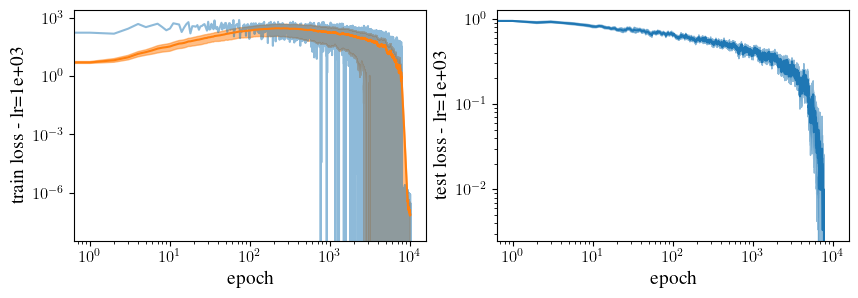

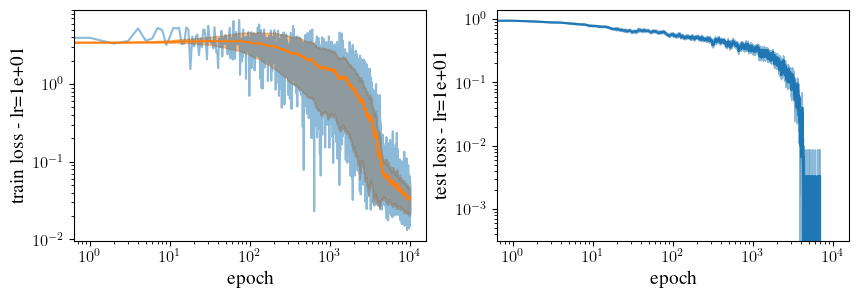

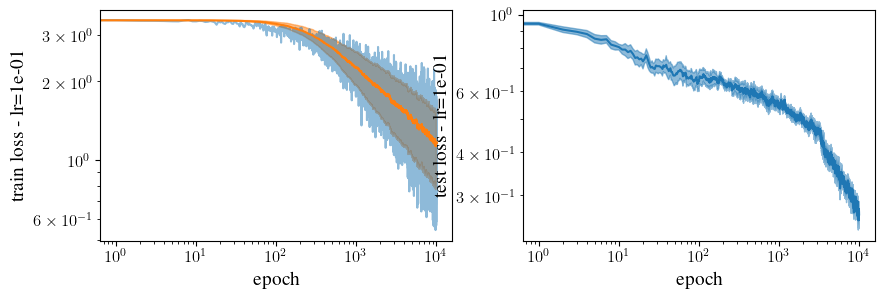

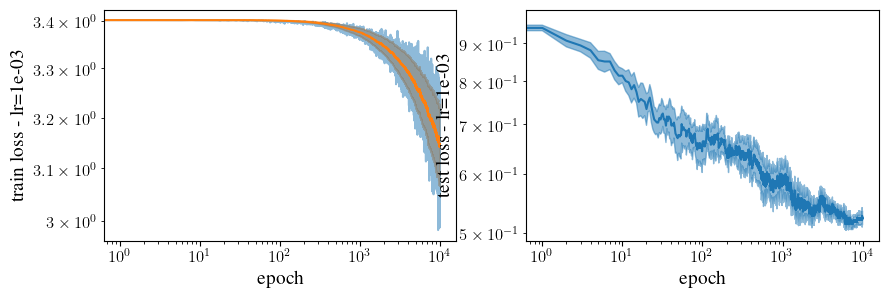

In [52]:
mean_train_losses = train_losses.mean(dim=0)
std_train_losses = train_losses.std(dim=0)
mean_test_losses = test_losses.mean(dim=0)
std_test_losses = test_losses.std(dim=0)

for j in range(num_models):
    train_loss = mean_train_losses[j]
    test_loss = mean_test_losses[j]
    train_std = std_train_losses[j]
    test_std = std_test_losses[j]
    lr = learning_rates[j]

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].plot(th.arange(nb_epoch), train_loss, label='train', alpha=.5)
    smooth_train_loss = ewma(train_loss, .99)
    smooth_train_std = ewma(train_std, .99)
    axes[0].plot(th.arange(nb_epoch), smooth_train_loss, label='train')
    axes[0].fill_between(th.arange(nb_epoch), smooth_train_loss - .5*smooth_train_std, smooth_train_loss + .5*smooth_train_std, alpha=.5, color='C1')
    axes[1].plot(th.arange(nb_epoch), test_loss, label='test')
    axes[1].fill_between(th.arange(nb_epoch), test_loss - .5*test_std, test_loss + .5*test_std, alpha=.5, color='C0')

    for i in range(2):
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_xlabel('epoch', fontsize=14)
        loss_type = {0: "train", 1: "test"}[i]
        axes[i].set_ylabel(f'{loss_type} loss - {lr=:.0e}', fontsize=14)